In [21]:
'''
!pip install mne
!pip install ipympl
!pip install mne-bids
!pip install pybv
!pip install python-picard
'''

%matplotlib notebook

# Descarga del dataset desde la web, correción del mismo y creacion de la estructura BIDS para poder trabajar facilmente con los datos

**OJO:** Solo realizar esto la primera vez que se cargue el notebook para crear todos los datos

[¡¡¡ Si ya están los datos cargados comienza a partir de la sección **PREPROCESAMIENTO** !!!](#scrollTo=BTPMUjW95Pb4&line=1&uniqifier=1)

## Descarga del dataset

Dataset obtenido de:

https://figshare.com/articles/dataset/Multi-channel_EEG_recordings_during_a_sustained-attention_driving_task/6427334/5

In [1]:
import urllib.request
import os.path

url = 'https://ndownloader.figshare.com/files/11821343'
dest = './eeg_raw.set'

if os.path.isfile(dest):
    print (f"File '{dest}' already downloaded")
else:
  print(f"Beginning file download from '{url}'")
  urllib.request.urlretrieve(url, dest)
  print(f"File download completed, file name: '{dest}'")

Beginning file download from 'https://ndownloader.figshare.com/files/11821343'
File download completed, file name: './eeg_raw.set'


In [2]:
import mne
import numpy as np

In [3]:
raw = mne.io.read_raw_eeglab('eeg_raw.set', preload=True)
raw.info

<ipython-input-3-428b291d8677>:1: RuntimeWarning: 1 channel names are too long, have been truncated to 15 characters:
['vehicle position']
  raw = mne.io.read_raw_eeglab('eeg_raw.set', preload=True)


<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FP2, F7, F3, FZ, F4, F8, FT7, FC3, FCZ, FC4, FT8, T3, C3, ...
 chs: 33 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>

## Correcciones y adiciones al dataset

### Tipo del canal de estimulos

In [4]:
stim_ch_name = raw.ch_names[-1]
raw.set_channel_types(mapping={stim_ch_name:'stim'})

un, counts = np.unique(raw.get_channel_types(), return_counts=True)
print(un)
print(counts)

['eeg' 'stim']
[32  1]


<ipython-input-4-19a4fee635b5>:2: RuntimeWarning: The unit for channel(s) vehicle positio has changed from V to NA.
  raw.set_channel_types(mapping={stim_ch_name:'stim'})


### Nombre de los canales para que sigan exactamente el nombre de la convencion 10-20


In [5]:
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3',
 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz',
 'P4', 'T6', 'A2', 'O1', 'Oz', 'O2', 'Vpos']

info = mne.create_info(ch_names=ch_names, sfreq=raw.info['sfreq'], ch_types=raw.get_channel_types())


new_raw = mne.io.RawArray(raw.get_data(), info)

montage = mne.channels.make_standard_montage('standard_1020')
new_raw.set_montage(montage = montage)

Creating RawArray with float64 data, n_channels=33, n_times=3152140
    Range : 0 ... 3152139 =      0.000 ...  6304.278 secs
Ready.


<RawArray | 33 x 3152140 (6304.3 s), ~793.7 MB, data loaded>

### Frecuencia de la red electrica a la que se realiza el experimento

In [6]:
new_raw.info['line_freq'] = 60

### Añadimos los eventos del dataset al nuevo RawArray

In [7]:
events, event_id = mne.events_from_annotations(raw)

new_raw.add_events(events, stim_channel='Vpos', replace=True)

Used Annotations descriptions: ['251', '252', '253', '254']


### Guardamos el dataset corregido en formato FIF

In [8]:
new_raw.save('./eeg_raw.fif', overwrite=True)

Writing E:\UNIVERSIDAD\TFG\TRABAJO\eeg_raw.fif
Closing E:\UNIVERSIDAD\TFG\TRABAJO\eeg_raw.fif
[done]


## Almacenamos los datos en el formato correcto segun la especificacion BIDS
https://mne.tools/mne-bids/stable/index.html

In [9]:
import mne_bids
import pathlib

In [10]:
raw = mne.io.read_raw('./eeg_raw.fif')

out_path = pathlib.Path('./data_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='driving',
                              run='01',
                              root=out_path)

# Añadimos los eventos tambien a los datos en formato BIDS
mne_bids.write_raw_bids(raw, bids_path=bids_path, events_data=events, event_id=event_id, overwrite=True, verbose=False)
# Parametro verbose=False para que no salga tanto texto

Opening raw data file ./eeg_raw.fif...
    Range : 0 ... 3152139 =      0.000 ...  6304.278 secs
Ready.
Opening raw data file ./eeg_raw.fif...
    Range : 0 ... 3152139 =      0.000 ...  6304.278 secs
Ready.
Reading 0 ... 3152139  =      0.000 ...  6304.278 secs...


BIDSPath(
root: data_BIDS
datatype: eeg
basename: sub-01_ses-01_task-driving_run-01_eeg.vhdr)

In [13]:
!rm 'eeg_raw.fif'
!rm 'eeg_raw.set'

# A partir de aqui se trabaja con los datos en formato BIDS

# Preprocesamiento

In [30]:
import mne
import mne_bids

import numpy as np

import pathlib

import matplotlib.pyplot as plt

import matplotlib

matplotlib.use('Qt5Agg')

In [15]:
bids_root = pathlib.Path('./data_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='driving',
                              run='01',
                              datatype='eeg',
                              root=bids_root)

raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()

Extracting parameters from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_eeg.vhdr...
Setting channel info structure...
Reading events from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_events.tsv.
Reading channel info from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_channels.tsv.
Reading in coordinate system frame CapTrak: None.
Reading electrode coords from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_electrodes.tsv.
The read in electrodes file is: 
 [('name', ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'O1', 'Oz', 'O2', 'Vpos']), ('x', ['-0.028230102732777596', '0.028615690767765045', '-0.06735513359308243', '-0.04818205162882805', '0.0002676595177035779', '0.049658745527267456', '0.06999924778938293', '-0.07742763310670853', '-0.057707447558641434', '0.00032673482201062143', '0.0596809908747673',

<ipython-input-15-233650a766ee>:10: RuntimeWarning: The unit for channel(s) Vpos has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-15-233650a766ee>:10: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Vpos']
  raw = mne_bids.read_raw_bids(bids_path)


<RawBrainVision | sub-01_ses-01_task-driving_run-01_eeg.eeg, 33 x 3152140 (6304.3 s), ~793.7 MB, data loaded>

## Downsampling

Se puede reducir el numero de muestras hasta `2*info['lowpass']`, es decir, el doble de la frecuencia máxima es el **minimo** valor con el que no se produce aliasing y por lo tanto no se pierde información.

**Ejemplo:** Si se ha hecho un filtro paso banda 1-50, entonces se puede hacer un downsample a 100 sin perder info

[Teorema de Nyquist](https://en.wikipedia.org/wiki/Nyquist_rate)

In [ ]:
resample_freq = raw.info['lowpass']*2 # Nyquist
raw = raw.resample(resample_freq, n_jobs=2)

print(f'Datos downsampleados al mínimo viable sin perder calidad {resample_freq} muestras/segundo')

1599 events found
Event IDs: [1 2 3 4]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:   13.5s
[Parallel(n_jobs=2)]: Done  33 out of  33 | elapsed:   21.0s finished


1599 events found
Event IDs: [1 2 3 4]
Datos downsampleadosa al mínimo viable sin perder calidad 500.0 muestras/segundo


## Filtro notch

Elimina una frecuencia en concreto de la señal

Es posible que no sea necesario realizarlo si se trabaja con **filtros paso banda que están por debajo de la frecuencia de 50 o 60 Hz**

In [ ]:
raw = raw.notch_filter([60, 120, 180])

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



## Filtro paso banda

Deja pasar un determinado rango de frecuencias de la señal [f1-f2]

In [ ]:
# @title Introduce los valores en Hz del filtro paso-banda

f1 =  0.1#@param {type:"number", min: 0.1}
f2 =  0.2#@param {type:"number", min: 0.1, max: 250}

if (l_freq < h_freq):
  raw = raw.filter(l_freq = f1, h_freq = f2)
else:
  print('Error: El valor de l_freq debe ser menor que el de h_freq')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.20 Hz)
- Filter length: 16501 samples (33.002 sec)



## ICA

Se recomienda filtrar los datos con un paso-banda de al menos f1 = 1Hz

In [ ]:
test = raw.copy().filter(l_freq=1, h_freq=35)

#Parametros del ICA
n_components = 0.999  # Should normally be higher, like 0.999!!
method = 'picard'
max_iter = 500  # Should normally be higher, like 500 or even 1000!!
fit_params = dict(fastica_it=5)
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
                            fit_params=fit_params,
                            random_state=random_state)
ica.fit(test)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (3.302 sec)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 346.8s.


<ICA | raw data decomposition, fit (picard): 3152140 samples, 17 components, channels used: "eeg">

In [ ]:
ica.plot_components()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[<MNEFigure size 702x696.24 with 17 Axes>]

Creating RawArray with float64 data, n_channels=17, n_times=3152140
    Range : 0 ... 3152139 =      0.000 ...  6304.278 secs
Ready.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

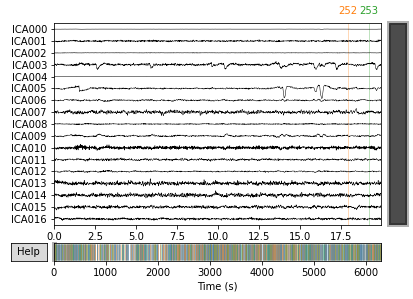

In [ ]:
ica.plot_sources(test)

Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

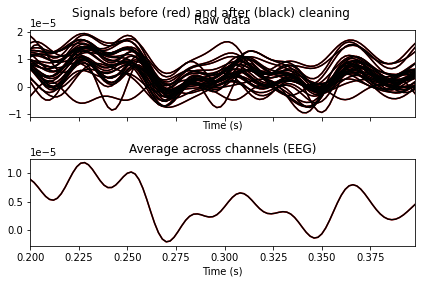

In [ ]:
ica.plot_overlay(test, picks='eeg', start=100, stop=200)

In [ ]:
ica.apply(test)

## Visualización

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

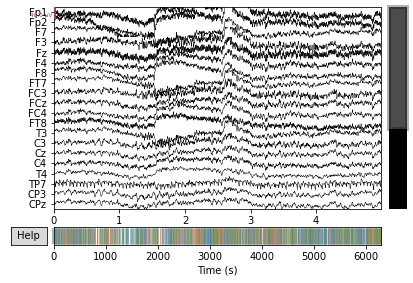

In [ ]:
raw.plot(duration=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Effective window size : 4.096 (s)


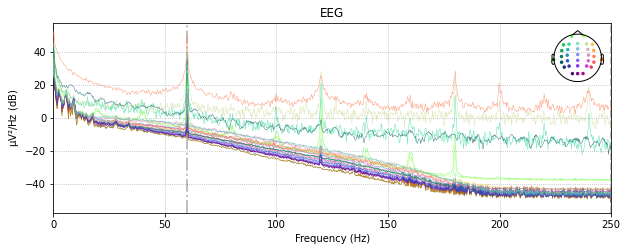

In [ ]:
raw.plot_psd()

## Visualización

In [ ]:
plot_size=(16,5)

# Data plot
sfreq = raw.info['sfreq'] # Si se ha hecho downsampling este valor disminuye automaticamente
tend = 10

data_ini, times_ini = raw[:-1, :int(sfreq * tend)]

fig = plt.subplots(figsize=plot_size)
plt.plot(times_ini, data_ini.T)
plt.legend(raw.ch_names[:-1], loc='best', ncol=4)
plt.xlabel('Tiempo(s)')
plt.ylabel('Voltaje($\mu V$)')
plt.title(f'Gráfica de los {len(raw.get_data())-1} canales EEG en los primeros {tend} segundos')

# PSD
fig, axis = plt.subplots(figsize=plot_size)
raw.plot_psd(ax=axis)

fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Effective window size : 4.096 (s)


# WIP

In [1]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [41]:
%matplotlib qt5
import mne
import mne_bids

import numpy as np

import pathlib

import matplotlib.pyplot as plt

import matplotlib

from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval

bids_root = pathlib.Path('./data_BIDS')

bids_path = mne_bids.BIDSPath(subject='01',
                              session='01',
                              task='driving',
                              run='01',
                              datatype='eeg',
                              root=bids_root)

raw = mne_bids.read_raw_bids(bids_path)
raw.load_data()

Extracting parameters from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_eeg.vhdr...
Setting channel info structure...
Reading events from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_events.tsv.
Reading channel info from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_channels.tsv.
Reading in coordinate system frame CapTrak: None.
Reading electrode coords from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_electrodes.tsv.
The read in electrodes file is: 
 [('name', ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'O1', 'Oz', 'O2', 'Vpos']), ('x', ['-0.028230102732777596', '0.028615690767765045', '-0.06735513359308243', '-0.04818205162882805', '0.0002676595177035779', '0.049658745527267456', '0.06999924778938293', '-0.07742763310670853', '-0.057707447558641434', '0.00032673482201062143', '0.0596809908747673',

<ipython-input-41-fc5229808373>:25: RuntimeWarning: The unit for channel(s) Vpos has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-41-fc5229808373>:25: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Vpos']
  raw = mne_bids.read_raw_bids(bids_path)


<RawBrainVision | sub-01_ses-01_task-driving_run-01_eeg.eeg, 33 x 3152140 (6304.3 s), ~793.7 MB, data loaded>

In [42]:
raw.pick_channels(['Fp1', 'Fp2', 'T3', 'T4','C3', 'C4', 'O1', 'O2'] ,ordered=True)
raw.crop(tmin=0, tmax=20*60, include_tmax=True)

<RawBrainVision | sub-01_ses-01_task-driving_run-01_eeg.eeg, 8 x 600001 (1200.0 s), ~36.6 MB, data loaded>

# Bandas EEG rango de frecuencia
## Theta 1-4
## Delta 4-8
## Alfa 8-12
## Beta 12-30

In [43]:
# No hace falta notch porq fmax = 30
raw_filtered = raw.copy().filter(l_freq=1, h_freq=30)

raw_filtered.resample(60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 sec)



<RawBrainVision | sub-01_ses-01_task-driving_run-01_eeg.eeg, 8 x 72000 (1200.0 s), ~4.4 MB, data loaded>

In [44]:
#Parametros del ICA
n_components = 0.999  # Should normally be higher, like 0.999!!
method = 'picard'
max_iter = 500  # Should normally be higher, like 500 or even 1000!!
fit_params = dict(fastica_it=5)
random_state = 42

ica = mne.preprocessing.ICA(n_components=n_components,
                            method=method,
                            max_iter=max_iter,
                            fit_params=fit_params,
                            random_state=random_state)
ica.fit(raw_filtered)
ica.apply(raw_filtered)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 8 components
Fitting ICA took 0.8s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


<RawBrainVision | sub-01_ses-01_task-driving_run-01_eeg.eeg, 8 x 72000 (1200.0 s), ~4.4 MB, data loaded>

# Generate artificial epochs every n-second

In [45]:
epochs = mne.make_fixed_length_epochs(raw_filtered, duration=2, preload=True)

Not setting metadata
Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Loading data for 600 events and 120 original time points ...
0 bad epochs dropped


In [46]:
reject_criteria = dict(eeg=200e-6) # 150 µV

flat_criteria = dict(eeg=15e-6)     # 10 µV

epochs.drop_bad(reject=reject_criteria, flat=flat_criteria, verbose=False)

<Epochs |  463 events (all good), 0 - 1.98333 sec, baseline off, ~3.4 MB, data loaded,
 '1': 463>

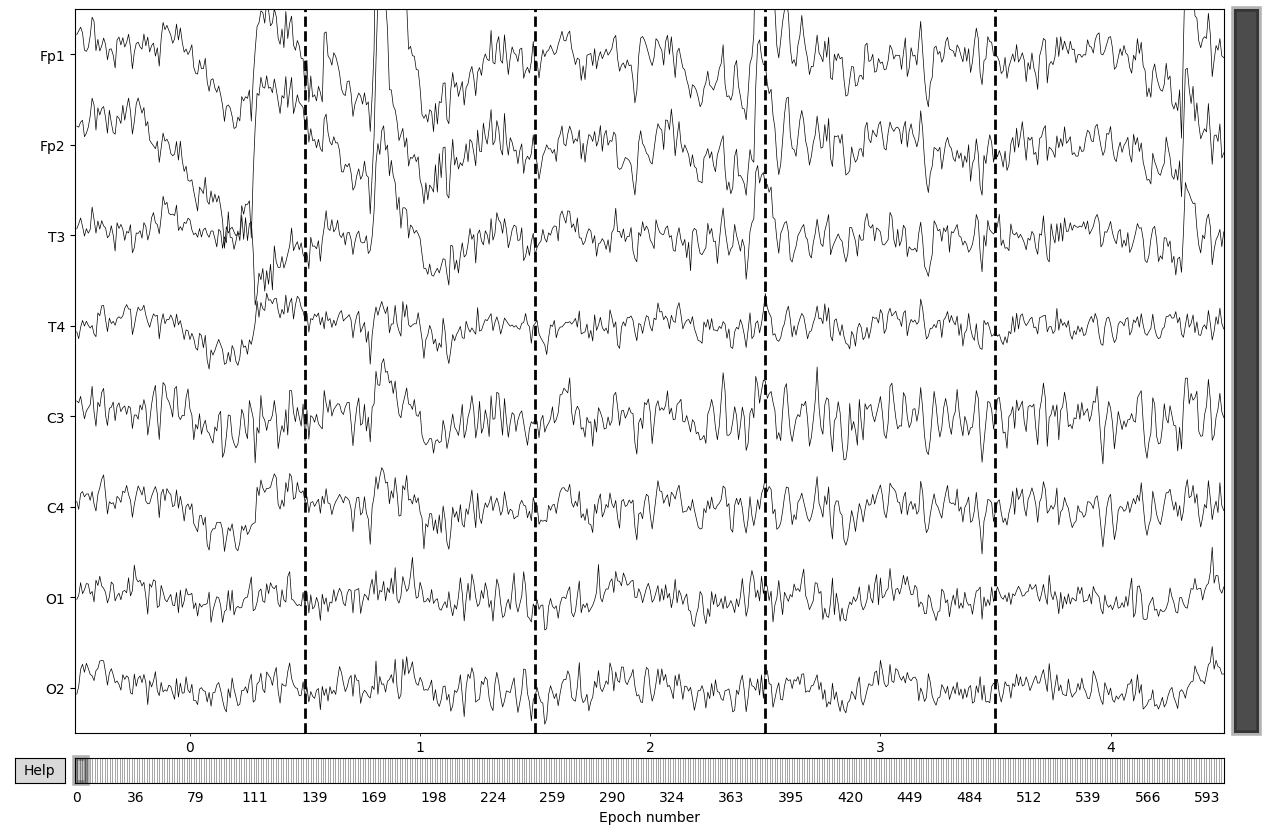

Dropped 0 epochs: 
Channels marked as bad: none


In [125]:
epochs.plot(n_epochs=5)

In [134]:
n_epochs = len(epochs)
data = epochs.get_data()

mean_vals = np.zeros(n_epochs)
median_vals = np.zeros(n_epochs)

for i in range(10): # Cambiar a n_epochs
    mean = np.mean(data[i][0])
    std = np.std(data[i][0])
    # \tVC:{std/mean}
    
    print(f'[{i:02}] mean={mean:.5e}\tstd:{std:.5e}\tvariance:{np.var(data[i][0]):.5e}\tp05:{np.percentile(data[i][0], 5):.5e}\tq1:{np.quantile(data[i][0], 0.25):.5e}\tmedian(q2):{np.median(data[i][0]):.5e}\tq3:{np.quantile(data[i][0], 0.75):.5e}\tp95:{np.percentile(data[i][0], 95):.5e}')

[00] mean=3.79064e-07	std:1.27713e-05	variance:1.63106e-10	p05:-2.72879e-05	q1:-6.16135e-06	median(q2):3.33544e-06	q3:8.41648e-06	p95:1.71236e-05
[01] mean=5.96205e-07	std:3.29796e-05	variance:1.08765e-09	p05:-2.81159e-05	q1:-1.77987e-05	median(q2):-7.70805e-06	q3:1.13653e-06	p95:7.21715e-05
[02] mean=-1.23665e-06	std:1.74930e-05	variance:3.06006e-10	p05:-2.01919e-05	q1:-1.10594e-05	median(q2):-2.03658e-06	q3:2.68817e-06	p95:1.03457e-05
[03] mean=1.54042e-06	std:1.36901e-05	variance:1.87419e-10	p05:-1.32571e-05	q1:-5.16405e-06	median(q2):-3.77041e-07	q3:4.25465e-06	p95:2.03821e-05
[04] mean=-4.89602e-07	std:1.13940e-05	variance:1.29823e-10	p05:-1.85926e-05	q1:-5.72809e-06	median(q2):-2.75496e-07	q3:4.57662e-06	p95:1.72659e-05
[05] mean=2.41167e-07	std:3.31701e-05	variance:1.10026e-09	p05:-2.92353e-05	q1:-1.85984e-05	median(q2):-5.35439e-06	q3:1.01088e-06	p95:8.62206e-05
[06] mean=-4.52048e-06	std:3.24660e-05	variance:1.05404e-09	p05:-5.55671e-05	q1:-2.01708e-05	median(q2):-2.05826e-06	

In [12]:
epochs.load_data().filter(l_freq=8, h_freq=12)
alpha_data = epochs.get_data()

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 99 samples (1.650 sec)



In [34]:
corr_matrix = mne.connectivity.envelope_correlation(alpha_data, combine=None)

In [36]:
first = corr_matrix[0]
last = corr_matrix[-1]
corr_matrices = [first, last]
color_lims = np.percentile(np.array(corr_matrices), [5, 95])
titles = ['First 2 Seconds', 'Last 2 Seconds']

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle('Correlation Matrices from First 2 Seconds and Last 2 Seconds')
for ci, corr_matrix in enumerate(corr_matrices):
    ax = axes[ci]
    ax.imshow(corr_matrix, clim=color_lims)
    ax.set_xlabel(titles[ci])
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.2, 0.025, 0.6])
cbar = fig.colorbar(ax.images[0], cax=cax)
cbar.set_label('Correlation Coefficient')

fig.show()

# Frequency bands analysis

In [438]:
iter_freqs = [
    ('Delta+Theta', 1, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 30)
]

In [445]:
reject_criteria = dict(eeg=200e-6) # 150 µV
flat_criteria = dict(eeg=15e-6)     # 10 µV

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne_bids.read_raw_bids(bids_path)
    raw.load_data()
    raw.pick_channels(['Fp1', 'Fp2', 'T3', 'T4','C3', 'C4', 'O1', 'O2'] ,ordered=True)
    raw.crop(tmin=0, tmax=2, include_tmax=True)
    
    raw.filter(fmin, fmax, n_jobs=4,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.
    
    epochs = mne.make_fixed_length_epochs(raw, duration=2, preload=True)    

    epochs.drop_bad(reject=reject_criteria, flat=flat_criteria, verbose=False)
    #epochs.subtract_evoked()
    
    
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs
del raw

Extracting parameters from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_eeg.vhdr...
Setting channel info structure...
Reading events from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_events.tsv.
Reading channel info from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_channels.tsv.
Reading in coordinate system frame CapTrak: None.
Reading electrode coords from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_electrodes.tsv.
The read in electrodes file is: 
 [('name', ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'O1', 'Oz', 'O2', 'Vpos']), ('x', ['-0.028230102732777596', '0.028615690767765045', '-0.06735513359308243', '-0.04818205162882805', '0.0002676595177035779', '0.049658745527267456', '0.06999924778938293', '-0.07742763310670853', '-0.057707447558641434', '0.00032673482201062143', '0.0596809908747673',

<ipython-input-445-a285309d73e7>:8: RuntimeWarning: The unit for channel(s) Vpos has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-445-a285309d73e7>:8: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['Vpos']
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 1000 original time points ...
0 bad epochs dropped
Extracting parameters from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_eeg.vhdr...
Setting channel info structure...
Reading events from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_events.tsv.
Read

<ipython-input-445-a285309d73e7>:15: RuntimeWarning: filter_length (1651) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  h_trans_bandwidth=1)  # in each band and skip "auto" option.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-445-a285309d73e7>:24: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  frequency_map.append(((band, fmin, fmax), epochs.average()))
<ipython-input-445-a285309d73e7>:8: RuntimeWarning: The unit for cha

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 1000 original time points ...
0 bad epochs dropped
Extracting parameters from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_eeg.vhdr...
Setting channel info structure...
Reading events from data_BIDS\sub-01\ses-01\eeg\sub-01_ses-01_task-driving_run-01_events.tsv.
R

<ipython-input-445-a285309d73e7>:15: RuntimeWarning: filter_length (1651) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  h_trans_bandwidth=1)  # in each band and skip "auto" option.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-445-a285309d73e7>:24: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  frequency_map.append(((band, fmin, fmax), epochs.average()))
<ipython-input-445-a285309d73e7>:8: RuntimeWarning: The unit for cha

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1 events and 1000 original time points ...
0 bad epochs dropped


<ipython-input-445-a285309d73e7>:15: RuntimeWarning: filter_length (1651) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  h_trans_bandwidth=1)  # in each band and skip "auto" option.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\usuario\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-445-a285309d73e7>:24: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  frequency_map.append(((band, fmin, fmax), epochs.average()))


In [446]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(0, 1000*2)

axes.ravel()[-1].set_xlabel('Time [ms]')

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')